In [ ]:
import numpy as np
import pandas as pd
import requests as rq
import matplotlib.pyplot as plt

from prophet import Prophet
from xgboost import XGBRegressor
import matplotlib.dates as mdates
from bs4 import BeautifulSoup as bs
from datetime import timedelta, date
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# **BASE HISTÓRICA E REQUISITOS DE TREINO**

### **ATUALIZAÇÃO DE DADOS**
- Para a extração de dados foram utilizadas as bibliotecas "bs4" e "request";

- A extração de dados leva em consideração a base de dados presente no desafio, sendo: https://br.investing.com/indices/bovespa-historical-data;

- O link direciona para o site no qual existe uma tabela com os últimos 30 dias da IBOVESPA, utilizando o scraping foi possível extrair essa tabela;

- Assim que a extração foi feita, desconsidera-se a data referente ao dia atual, pois há a possibilidade da bolsa de valores não está fechada. A data atual será o indicador chave para a predição.

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0',
    'X-Requested-With': 'XMLHttpRequest',
    'Content-Type': 'application/x-www-form-urlencoded'
}


url = 'https://br.investing.com/indices/bovespa-historical-data'
response = rq.get(url, headers=headers)

soup = bs(response.content)
tabela = soup.find('table')


actual_df = pd.read_html(str(tabela), parse_dates=['Data'], index_col='Data')[0].drop_duplicates()

today = date.today()
actual_df = actual_df.query('index < @today')
actual_df['Var%'] = actual_df['Var%'] .str.replace('+', '')

### **TRATAMENTOS INICIAIS**
- Após a realização do scraping foi realizado um concat, com uma base histórica baixada manualmente (considerando o intervalo de 02/01/2001 até act/2025), esse concat serve para adicionar os dados diários à base histórica.

- A remoção de duplicados é essencial para que o historic_df mantenha sua estrutura propícia às análises futuras, também é necessário garantir que a tabela esteja ordenada pelo sort_index();

- Há também um tratamento das colunas "Var%" e "Vol.", com o objetivo de converter todos os valores da tabela para númerico (float).

In [ ]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')
historic_df = pd.concat([historic_df, actual_df])

historic_df = historic_df[~historic_df.index.duplicated(keep='last')]
historic_df = historic_df.sort_index()


historic_df.to_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv')

historic_df = historic_df.sort_index()

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')

historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

### **CRIANDO A TREND LINE**
- A **trend line** é um indicador de diferença entre o ponto inicial e o ponto final estudado;

- Foi realizdo uma conta simples do delta entre os dois extremos divindo pela quantidade de itens;

- Após este cálculo, criou-se uma coluna com a soma do line_trend * nº index atual + ponto inicial, a ideia foi desenhar uma linha entre os dois pontos para indicar a tendência. 

In [ ]:
delta_date = historic_df['Último'].iloc[-1] - historic_df['Último'].iloc[0]
line_trend = delta_date/(len(historic_df)-1)
historic_df['Trend'] = (line_trend * range(len(historic_df))) + historic_df['Último'].iloc[0]

### **PLOT PARA AVALIAÇÃO INICIAL**
Plot para visualização inicial dos dois dados chaves para a predição: 'Último', corresponde à cotação de fechamento, 'Var%' o quanto essa cotação variou em relação ao dia anterior. Utilizou-se a **média móvel 30d** para facilitar a visualização das linhas. A linha trend indica o ponto inicial e final da coluna 'Último'.

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))


line1, = ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.set_xlabel('Data')
ax.set_ylabel('Variação da Bolsa (%)')
ax.tick_params(axis='y')


ay = ax.twinx()
line2, = ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
line3, = ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(), 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(),
         color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.set_ylabel('Fechamento da Bolsa')
ay.tick_params(axis='y')


lines = [line3, line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('Média Móvel 30 dias - Variação % e Fechamento')
fig.tight_layout()

# Exibir gráfico
plt.show()

### **APLICANDO TESTE ADF**
- Teste na coluna último para indicar se é estacionário ou não. Como o valor de P-Value é maior que 0,05 indica que não é uma série estacionária. Sendo assim, há necessidade de diferenciação para que alguns modelos funcionem, como o ARIMA por exemplo.

In [ ]:
historic_var_df = historic_df[['Último']]
X = historic_var_df[['Último']].values

result = adfuller(X)

print('Teste ADF')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Value: {result[1]}')
print('Valores críticos:')

for key, value in result[4].items():
  print(f'\t{key}: {value}')


### **CRIANDO BASE DE TREINO E TESTE**
- A base treino leva em consideração um timedelta de 7d da base histórica e leva em consideração as seguintes feactures:

    - Calendário - Com o dia, número da semana, mês e ano;

    - Lag 365: Considera os últimos 365 resultados (valor respeitando o limite da ACF);

    - Média Móvel (Rolling Mean) - métrica que calcula a média dos valores de uma série temporal em uma janela de tempo móvel (window=n_lags = 365);

    - Desvio Padrão Móvel (Rolling Standard Deviation) - mede a volatilidade ou dispersão dos valores em uma janela de tempo móvel (window = n_lags= 365);

    - Média Móvel Exponencial (Exponential Moving Average - EMA) - é uma variação da média móvel que dá mais peso aos valores mais recentes;

    - Desvio Padrão Móvel Exponencial (Exponential Moving Standard Deviation) - é uma versão do desvio padrão móvel que dá mais peso aos valores mais recentes.

In [ ]:
historic_df['day'] = historic_df.index.day
historic_df['week_of_year'] = [dt.weekofyear for dt in historic_df.index]
historic_df['month'] = historic_df.index.month
historic_df['year'] = historic_df.index.year


plt.figure(figsize=(14, 6))
plot_acf(historic_df['Último'].dropna(), ax=plt.gca(), lags=365)
plt.title('Função de Autocorrelação (ACF)')


n_lags = 365
for lag in range(1, n_lags + 1):
    historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)


historic_df[f'rolling_mean_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).mean().shift(1)
historic_df[f'rolling_std_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).std().shift(1)

historic_df[f'ema_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).mean().shift(1)
historic_df[f'ema_std_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).std().shift(1)


predictors = [
    'day',
    'week_of_year',
    'month',
    'year',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
]


train_end = (date.today()-timedelta(7)).strftime('%Y-%m-%d')

df_train = historic_df[:train_end]
df_test = historic_df[train_end:]

# **BENCHMARKING DE MODELOS DE TREINO**

### **CRIANDO O NAIVE PREDICT**
- O Naive Predict serve como Baseline para comparar a eficácia dos outros modelos de predição. Ele leva em consideração que os futuros fechamentos serão iguais à última cotação histórica. Sendo um modelo simples é o ideial para avaliar se os outros modelos serão descartados ou não.

In [ ]:
naive_pred = pd.Series(index=historic_df.index, dtype='float64')
naive_pred.loc[df_train.index] = historic_df['Último'].shift(1).loc[df_train.index]
last_train_value = historic_df['Último'].loc[df_train.index[-1]]
naive_pred.loc[df_test.index] = last_train_value


# Evaluation


mse_naive = mean_squared_error(df_test['Último'][1:], naive_pred.loc[df_test.index][1:])
print(f'Naive Baseline MSE: {mse_naive}')

### **CRIANDO XGBoost PREDICT**

- XGBoost é um algoritmo de machine learning baseado em gradient boosting, que combina várias árvores de decisão fracas para criar um modelo robusto. Pode ser complexo para ajustar hiperparâmetros, exige mais recursos computacionais em comparação a modelos mais simples e é menos interpretável. Neste modelo foi aplicado 100 splits para identificação do melhor modelo de XGBoost para a predição.

In [ ]:

# Define features and target
X_train = df_train[predictors]
y_train = df_train['Último']
X_test = df_test[predictors]
y_test = df_test['Último']

# TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=100)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train with cross-validation
xgb_models = []
mse = []
count = 0
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb.fit(X_tr, y_tr)
    val_pred = xgb.predict(X_val)
    # print(f'{count} Validation MSE: {mean_squared_error(y_val, val_pred)}')
    count = count + 1 
    mse.append(mean_squared_error(y_val, val_pred))
    xgb_models.append(xgb)

best_model_idx = mse.index(min(mse))
print(f'Best Model Idx: {best_model_idx}')

xgb = xgb_models[best_model_idx]

# Predict on the test set
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost MSE: {mse_xgb}')

xgb_pred_series = pd.Series(xgb_pred, index=df_test.index, name='pred')
xgb_pred_df = xgb_pred_series.astype('float64')

### **CRIANDO ARIMA PREDICT**
- ARIMA é um modelo estatístico clássico para análise de séries temporais. Ele combina três componentes: AutoRegressivo (AR), Diferenciação (I) e Média Móvel (MA). Neste exemplo abaixo, por não ser uma série estacionária utilzou-se d =1 para fazer a diferenciação.

In [ ]:
# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plt.subplot(122)
plot_pacf(historic_df['Último'].dropna(), ax=plt.gca(), lags=40)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()

p = 3 
d = 1
q = 40

model_arima = ARIMA(df_train['Último'], order=(p, d, q))
resultado_arima = model_arima.fit()

arima_pred = resultado_arima.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)

arima_mse = mean_squared_error(y_test, arima_pred)
print(f'ARIMA MSE: {arima_mse}')

arima_pred.index = df_test.index 
arima_pred_series = pd.Series(arima_pred, index=df_test.index, name='pred')
arima_pred_df = arima_pred_series.astype('float64')

### **CRIANDO O PROPHET PREDICT**
- o Prophet é um modelo de previsão de séries temporais projetado para ser simples e intuitivo. Ele lida automaticamente com tendências, sazonalidade e feriados. Para aplicar este modelo foi necessário algumas modificações do df_train original, pois sua estrutura é fixa, pedindo uma coluna y e uma ds obrigatoriamente.

In [ ]:
data = df_train[['Último']].copy()
data['ds'] = data.index

data.rename(columns={'Último': 'y'}, inplace=True)

delta_days = (df_test.index[-1]-df_train.index[-1]).days


model = Prophet()
model.fit(data)


future = model.make_future_dataframe(periods=delta_days)
prophet_pred = model.predict(future)


fig = model.plot(prophet_pred)


plt.title('Previsão usando o Prophet')
plt.show()

prophet_pred.set_index('ds', inplace=True)
prophet_pred_series = pd.Series(prophet_pred['yhat'], index=df_test.index, name='pred')
prophet_pred_df = prophet_pred_series.astype('float64')


### **CRIANDO O RANDOM FOREST PREDICT**
- Forest é um algoritmo de ensemble que combina múltiplas árvores de decisão para melhorar a precisão e reduzir overfitting. Ele usa bagging (bootstrap aggregating) para treinar cada árvore em subconjuntos aleatórios dos dados. Utilizou-se os mesmos predictors usados no XGBoost, considerando um n-estimators = 100.

In [ ]:
df_train_rf = df_train.dropna()
X_train_rf = df_train_rf[predictors]
y_train_rf = df_train_rf['Último']

df_test_rf = df_test.dropna()
X_test_rf = df_test_rf[predictors]
y_test_rf = df_test_rf['Último'].loc[X_test_rf.index]


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


rf_model.fit(X_train_rf, y_train_rf)
rf_pred = rf_model.predict(X_test_rf)


rf_pred_series = pd.Series(rf_pred, index=df_test.index, name='pred')
rf_pred_df = rf_pred_series.astype('float64')

### **TESTE DE BENCHMARKING**
- Os testes utilizados para avaliar a eficiência dos modelos foram:

    - **MAE (Mean Absolute Error)**: é a média das diferenças absolutas entre os valores reais e os valores previstos. Ele mede o erro médio das previsões, sem considerar a direção (positiva ou negativa).

    - **RMSE (Root Mean Squared Error)**: é a raiz quadrada da média dos erros ao quadrado. Ele mede a magnitude média do erro, dando mais peso a erros grandes.

    -  **MAPE (Mean Absolute Percentage Error)**: é a média das diferenças percentuais absolutas entre os valores reais e os valores previstos. Ele mede o erro percentual médio.

    - **Accuracy (%)**: é uma métrica derivada do MAPE. Ela representa a porcentagem de precisão do modelo, calculada como:

Com base nessa avaliação o modelo utilizado para a predição foi o Random Forest, pois teve perfomance melhor em todos os quesitos

In [ ]:

mae_naive = mean_absolute_error(df_test['Último'], naive_pred[train_end:])
rmse_naive = mean_squared_error(df_test['Último'], naive_pred[train_end:])
mape_naive = 100 * mean_absolute_percentage_error(df_test['Último'], naive_pred[train_end:])

mae_xgb = mean_absolute_error(df_test['Último'], xgb_pred)
rmse_xgb = mean_squared_error(df_test['Último'], xgb_pred)
mape_xgb = 100 * mean_absolute_percentage_error(df_test['Último'], xgb_pred)

mae_arima = mean_absolute_error(df_test['Último'], arima_pred)
rmse_arima = mean_squared_error(df_test['Último'], arima_pred)
mape_arima = 100 * mean_absolute_percentage_error(df_test['Último'], arima_pred)

mae_prophet = mean_absolute_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])
rmse_prophet = mean_squared_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])
mape_prophet = 100 * mean_absolute_percentage_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])

mae_rf = mean_absolute_error(df_test['Último'], rf_pred)
rmse_rf = mean_squared_error(df_test['Último'], rf_pred)
mape_rf = 100 * mean_absolute_percentage_error(df_test['Último'], rf_pred)


resultados = pd.DataFrame(
    {
        'Modelo': ['XGBoost', 'Naive', 'Arima', 'Prophet', 'Random Forest'],
        'MAE': [mae_xgb, mae_naive, mae_arima, mae_prophet, mae_rf],
        'RMSE': [rmse_xgb, rmse_naive, rmse_arima, rmse_prophet, rmse_rf],
        'MAPE (%)': [mape_xgb, mape_naive, mape_arima, mape_prophet, mape_rf],
        'Accuracy (%)': [
            100 - mape for mape in [mape_xgb, mape_naive, mape_arima, mape_prophet, mape_rf]
        ],
    }
).sort_values('MAPE (%)').reset_index(drop=True)


,Modelo,MAE,RMSE,MAPE (%),Accuracy (%)
0,Random Forest,0.796306,0.792641,0.609240,99.390760
1,Naive,2.188800,6.292212,1.660332,98.339668
2,XGBoost,2.394431,6.138360,1.826616,98.173384
3,Arima,2.773772,9.273945,2.106201,97.893799
4,Prophet,3.477421,13.917637,2.642106,97.357894


### **VISUALIZAÇÃO DE TODOS OS TESTE**

Visualização dos modelos de predição vs Actual (valor efetivo no período de 5 dias).

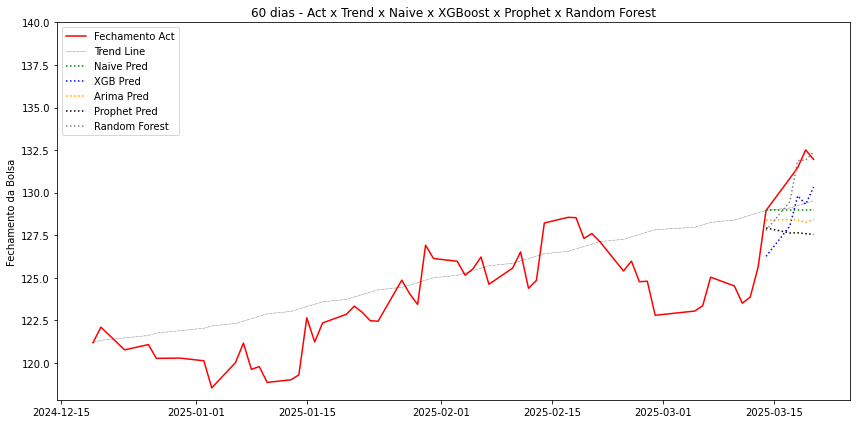

In [ ]:
historic_filter = historic_df.copy().tail(60)
delta_date = historic_filter[:train_end]['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter[:train_end])-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]


naive_filter = naive_pred.tail(20)


fig, ax = plt.subplots(figsize=(12,6))

# Fechamento act
line2, = ax.plot(historic_filter.index, historic_filter['Último'], color='red', label='Fechamento Act')

# Linha de tendência
line3, = ax.plot(historic_filter.index, historic_filter['Trend'], 
                 color='black', label='Trend Line', linestyle=':', linewidth=0.5)

# Previsão Naive 
line4, = ax.plot(df_test.index, naive_filter.loc[df_test.index], color='green', linestyle=':', linewidth=1.5, label='Naive Pred')

# Previsão XGBoost
line5, = ax.plot(df_test.index, xgb_pred_df.loc[df_test.index], color='blue', linestyle=':', linewidth=1.5, label='XGB Pred')

# Previsão Arima
line6, = ax.plot(df_test.index, arima_pred_df.loc[df_test.index], color='orange', linestyle=':', linewidth=1.5, label='Arima Pred')

# Previsão Prophet
line7, = ax.plot(df_test.index, prophet_pred_df.loc[df_test.index], color='black', linestyle=':', linewidth=1.5, label='Prophet Pred')

# Previsão Prophet
line8, = ax.plot(df_test.index, rf_pred_df.loc[df_test.index], color='gray', linestyle=':', linewidth=1.5, label='Random Forest')

ax.set_ylabel('Fechamento da Bolsa')
ax.tick_params(axis='y')


lines = [line2, line3, line4, line5, line6, line7, line8]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')
ax.set_ylim(top=140)


plt.title('60 dias - Act x Trend x Naive x XGBoost x Prophet x Random Forest')
fig.tight_layout()

plt.show()

# **PREDIÇÃO DE VALORES FUTUROS**

### **CRIAÇÃO DE INTERVALO DE SEGURANÇA COM RANDOM FOREST**

- O intervalo de confiança está sendo calculado usando 1.96 como o multiplicador do desvio padrão (std_dev). Esse valor corresponde a um intervalo de confiança de 95% em uma distribuição normal (Gaussiana).
    - O valor **1.96** é o quantil da distribuição normal padrão (média = 0, desvio padrão = 1) que cobre **95% da área sob a curva**.

        - Em uma distribuição normal:

            - ±1.96 desvios padrão em torno da média abrange aproximadamente 95% dos dados.

            - Isso significa que há uma probabilidade de 95% de que o valor real esteja dentro desse intervalo.

In [ ]:
predictions = np.array([tree.predict(X_test_rf) for tree in rf_model.estimators_])

# Média das previsões (previsão final)
rf_pred = predictions.mean(axis=0)
std_dev = predictions.std(axis=0)
lower_bound = rf_pred - 1.96 * std_dev  # Intervalo inferior
upper_bound = rf_pred + 1.96 * std_dev  # Intervalo superior

rf_intervalo = pd.DataFrame({
    'pred': rf_pred,
    'lower': lower_bound,
    'upper': upper_bound
}, index=df_test.index)

### **VISUALIZAÇÃO DE PREDIÇÃO COM INTERVALO DE SEGURANÇA RF**

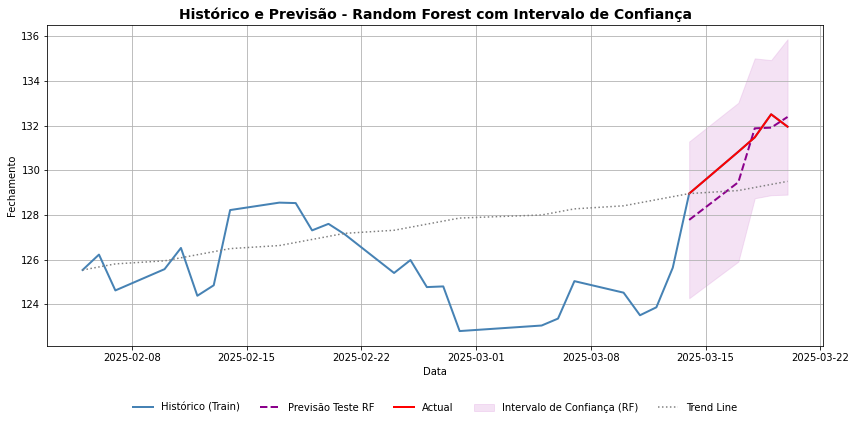

In [28]:
historic_filter = historic_df.copy().tail(30)
delta_date = historic_filter[:train_end]['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter[:train_end])-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

fig, ax = plt.subplots(figsize=(12,6))

# Plot histórico
ax.plot(historic_filter.index, historic_filter['Último'], label='Histórico (Train)', color='steelblue', linewidth=2)

# Plot Previsão Random Forest
ax.plot(rf_intervalo.index, rf_intervalo['pred'], label='Previsão Teste RF', color='darkmagenta', linestyle='--', linewidth=2)
ax.plot(df_test.index, df_test['Último'], label='Actual', color='red', linestyle='-', linewidth=2)

# Plot faixa de intervalo de confiança (shaded area)
ax.fill_between(rf_intervalo.index, 
                rf_intervalo['lower'], 
                rf_intervalo['upper'], 
                color='plum', alpha=0.3, label='Intervalo de Confiança (RF)')


ax.plot(historic_filter.index, historic_filter['Trend'], color='gray', linestyle=':', linewidth=1.5, label='Trend Line')



ax.set_title('Histórico e Previsão - Random Forest com Intervalo de Confiança', fontsize=14, fontweight='bold')
ax.set_ylabel('Fechamento')
ax.set_xlabel('Data')


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)
ax.grid(True)
plt.tight_layout()
plt.show()


### **PREDIÇÃO DOS PRÓXIMOS 3 DIAS - RF**

- Os códigos abaixo criam o cenário preditivo para os próximos 3 dias, levando em consideração o modelo RF treinado. 

- A var(%) retorna ao estudo como resultado da predição junto à coluna 'Último', essas duas informações são plotadas no gráfico final.

In [ ]:
historic_pred_df = historic_df.copy()

historic_pred_df.drop(columns=['Abertura','Máxima','Mínima','Vol (M)','Var%', 'Trend'], axis=1, inplace=True)

index_pred = [today + timedelta(days=i) for i in range(3)]
index_pred = [pd.to_datetime(date) for date in index_pred]

df_pred = pd.DataFrame(columns=[predictors], index=index_pred)


df_pred['day'] = df_pred.index.day
df_pred['week_of_year'] = df_pred.index.isocalendar().week 
df_pred['month'] = df_pred.index.month 
df_pred['year'] = df_pred.index.year

predictions_final = []

for step in range(3):
    data_pred = pd.to_datetime(today + timedelta(days=step))

    for lag in range(1, 366):
        df_pred.loc[data_pred, f'lag_{lag}'] = historic_pred_df['Último'].iloc[-lag]


    df_pred.loc[data_pred, f'rolling_mean_{n_lags}'] = historic_pred_df['Último'].rolling(window=n_lags).mean().iloc[-1]
    df_pred.loc[data_pred, f'rolling_std_{n_lags}'] = historic_pred_df['Último'].rolling(window=n_lags).std().iloc[-1]


    df_pred.loc[data_pred, f'ema_{n_lags}'] = historic_pred_df['Último'].ewm(span=n_lags).mean().iloc[-1]
    df_pred.loc[data_pred, f'ema_std_{n_lags}'] = historic_pred_df['Último'].ewm(span=n_lags).std().iloc[-1]


    df_pred.columns = [str(col[0]) if isinstance(col, tuple) else str(col) for col in df_pred.columns]


    rf_pred = rf_model.predict(df_pred.loc[[data_pred]])
    

    prediction = np.array([tree.predict(df_pred.loc[[data_pred]])[0] for tree in rf_model.estimators_])
    predictions_final.append(prediction)


    new_row = df_pred.loc[[data_pred]].copy()
    new_row['Último'] = float(rf_pred)
    historic_pred_df = pd.concat([historic_pred_df, new_row])

predictions_final = np.array(predictions_final)

rf_pred_final = predictions_final.mean(axis=1)
std_dev_final = predictions_final.std(axis=1)
lower_bound_final = rf_pred_final - 1.96 * std_dev_final
upper_bound_final = rf_pred_final + 1.96 * std_dev_final


dates_pred = [pd.to_datetime(today + timedelta(days=i)) for i in range(3)]

rf_intervalo_final = pd.DataFrame({
    'pred': rf_pred_final,
    'lower': lower_bound_final,
    'upper': upper_bound_final
}, index=dates_pred)


historic_pred_df['Var%'] = round((historic_pred_df['Último'] /historic_pred_df['Último'].shift(1)-1)*100,2) 


rf_intervalo_final = rf_intervalo_final.merge(historic_pred_df[['Var%']], 
                                              how='left', 
                                              left_index=True, 
                                              right_index=True)


### **VISUALIZAÇÃO DE PREDIÇÃO FINAL**

**Actual:**
Representa os valores reais observados dos dados. Esta série mostra os dados históricos ou reais que estão sendo analisados.

**Previsão Teste RF:**
Indica as previsões feitas pelo modelo Random Forest (RF) para o período de teste. Esta série mostra como o modelo se ajusta aos dados de teste.

**Intervalo de Confiança (RF):**
Representa o intervalo de confiança associado às previsões do Random Forest da base de testes. 

**Trend Line:**
Uma linha de tendência que pode ser usada para destacar a direção geral dos dados ao longo do tempo. Esta linha ajuda a identificar padrões ou tendência dos próximos dias com base na evolução do ponto inicial do actual até o ponto final.

**Última Cotação Histórica:**
Refere-se ao último valor observado nos dados históricos antes do início das previsões. Este ponto é importante para entender onde os dados reais terminam e as previsões começam.

**Previsão RF (+3 dias):**
Representa as previsões do modelo Random Forest para os próximos três dias. Esta série estende as previsões além do período efetivo e é a principal linha deste estudo.

**IC (+3 dias RF):**
Indica o intervalo de confiança para as previsões dos próximos três dias feitas pelo Random Forest.

**Início Previsão Futura:**
Marca o ponto no tempo onde as previsões futuras começam. Este ponto separa os dados históricos das previsões.


Ao final do código é feito um download na pasta Historico de Pred, no qual contém todas as predições para cada dia.

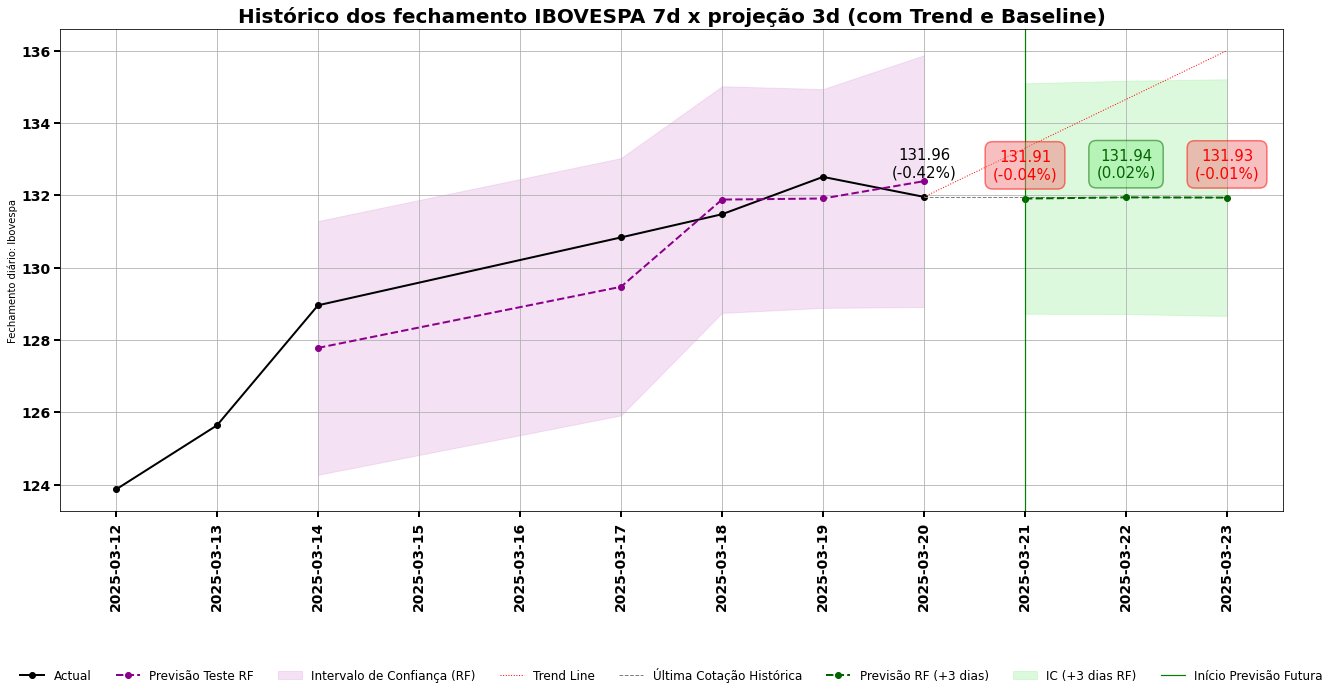

In [29]:
historic_filter = historic_pred_df.copy().tail(10)
delta_date = historic_filter[:pd.to_datetime(today-timedelta(1))]['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter[:pd.to_datetime(today-timedelta(1))])-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]


fig, ax = plt.subplots(figsize=(20, 10))

# Plot histórico
ax.plot(historic_filter[:pd.to_datetime(today - timedelta(1))].index, 
        historic_filter[:pd.to_datetime(today - timedelta(1))]['Último'], 
        label='Actual', color='black', linewidth=2, marker='o')

# Adicionar rótulo de dados no último dia do Actual
ultimo_dia_actual = historic_filter[:pd.to_datetime(today - timedelta(1))].index[-1]
ultimo_valor_actual = historic_filter[:pd.to_datetime(today - timedelta(1))]['Último'].iloc[-1]
ultimo_var_percentual = historic_filter[:pd.to_datetime(today - timedelta(1))]['Var%'].iloc[-1]


texto_anotacao = f'{ultimo_valor_actual:.2f}\n({ultimo_var_percentual:.2f}%)'
ax.annotate(texto_anotacao, 
            xy=(ultimo_dia_actual, ultimo_valor_actual), 
            xytext=(0, 20),
            textcoords='offset points', 
            fontsize=15, color='black', ha='center') 


# Plot Previsão Random Forest
ax.plot(rf_intervalo.index, rf_intervalo['pred'], 
        label='Previsão Teste RF', color='darkmagenta', linestyle='--', linewidth=2, marker='o')

# Plot faixa de intervalo de confiança (shaded area)
ax.fill_between(rf_intervalo.index, 
                rf_intervalo['lower'], 
                rf_intervalo['upper'], 
                color='plum', alpha=0.3, label='Intervalo de Confiança (RF)')


# Linha de referência (Trend Line) - apenas a partir de today
ax.plot(historic_filter[pd.to_datetime(today-timedelta(1)):].index, 
        historic_filter[pd.to_datetime(today-timedelta(1)):]['Trend'], 
        color='red', linestyle=':', linewidth=1, label='Trend Line')


# Linha horizontal da última cotação histórica (apenas a partir de today)
ultima_cotacao = historic_filter['Último'][:pd.to_datetime(today - timedelta(1))].iloc[-1]
ax.hlines(y=ultima_cotacao, xmin=pd.to_datetime(today-timedelta(1)), xmax=historic_filter.index[-1], 
          color='gray', linestyle='--', linewidth=1.0, label='Última Cotação Histórica')


# Plot Previsão Futura RF (+3 dias)
ax.plot(rf_intervalo_final.index, rf_intervalo_final['pred'], 
        label='Previsão RF (+3 dias)', color='darkgreen', linestyle='--', linewidth=2, marker='o')
for i, (data, valor) in enumerate(zip(rf_intervalo_final.index, rf_intervalo_final['pred'])):
    var_percentual = rf_intervalo_final['Var%'].iloc[i]
    texto_anotacao = f'{valor:.2f}\n({var_percentual:.2f}%)'
    
   
    if var_percentual > 0:
        cor_texto = 'darkgreen' 
        cor_fundo = 'lightgreen'  
    else:
        cor_texto = 'red' 
        cor_fundo = 'lightcoral'  
    
   
    ax.annotate(texto_anotacao, 
                xy=(data, valor), 
                xytext=(0, 20), 
                textcoords='offset points', 
                fontsize=15, color=cor_texto, ha='center', 
                bbox=dict(boxstyle='round,pad=0.5', 
                        facecolor=cor_fundo, 
                        edgecolor=cor_texto,  
                        linewidth=1.5, 
                        alpha=0.5))


# Intervalo de confiança da previsão futura
ax.fill_between(rf_intervalo_final.index, 
                rf_intervalo_final['lower'], 
                rf_intervalo_final['upper'], 
                color='lightgreen', alpha=0.3, label='IC (+3 dias RF)')

# Linha vertical separando histórico/teste da previsão futura
ax.axvline(x=rf_intervalo_final.index[0], color='green', linestyle='-', 
           linewidth=1.2, label='Início Previsão Futura')



ax.xaxis.set_major_locator(mdates.DayLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.xticks(rotation=90) 

ax.tick_params(axis='x', labelsize=14, width=2, length=6, color='black') 
for label in ax.get_xticklabels():
    label.set_fontweight('bold')


ax.tick_params(axis='y', labelsize=14, width=2, length=6, color='black') 
for label in ax.get_yticklabels():
    label.set_fontweight('bold')  



ax.set_title('Histórico dos fechamento IBOVESPA 7d x projeção 3d (com Trend e Baseline)', 
             fontsize=20, fontweight='bold')

ax.set_ylabel('Fechamento diário: Ibovespa')


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=8, frameon=False, fontsize=12)
ax.grid(True)
plt.tight_layout()



plt.savefig(fr'Historico de Pred\{today.strftime("%Y-%m-%d")}. {rf_intervalo_final.loc[pd.to_datetime(today), "Var%"]}.jpeg', dpi=300, bbox_inches='tight')
plt.show()
